In [70]:
# !pip install numpy
# !pip install pandas
# !pip install tqdm
# !pip install SimpleITK
# !pip install torch
# !pip install matplotlib

In [1]:
import os
import glob
import copy
import time

import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
from collections import namedtuple
import SimpleITK as sitk

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

In [2]:
df_annotations = pd.read_csv('C:/Users/Taeho/Downloads/lung_cancer_project/data/annotations.csv')
df_annotations.seriesuid[0]

# seriesuid : ct 스캔 식별값

'1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860'

In [3]:
df_annotations[df_annotations.seriesuid =='']

,seriesuid,coordX,coordY,coordZ,diameter_mm


In [4]:
df_candidates = pd.read_csv("C:/Users/Taeho/Downloads/lung_cancer_project/data/candidates_V2/candidates_V2.csv")
df_candidates[df_candidates.seriesuid == '1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084993415992563148335']

,seriesuid,coordX,coordY,coordZ,class
753997,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,12.320000,27.430000,-160.210000,0
753998,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,-26.471472,30.397506,-30.800304,0
753999,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,83.679555,40.991289,-137.473889,0
754000,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,43.160000,-55.970000,-101.310000,0
754001,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,-88.600000,16.910000,-176.340000,0
...,...,...,...,...,...
754970,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,-33.400000,-64.200000,-115.560000,0
754971,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,56.236359,70.352400,-203.446236,0
754972,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,-97.104221,55.738289,-203.879785,0
754973,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,-65.470000,59.670000,-136.370000,0


In [5]:
# class가 1이고 seriesuid가 특정 값인 데이터 추출
df_filtered = df_candidates[(df_candidates['class'] == 1) & (df_candidates['seriesuid'] == '1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084993415992563148335')]
df_filtered

,seriesuid,coordX,coordY,coordZ,class
754090,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,-29.720000,24.620000,-156.010000,1
754622,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,42.895122,74.251037,-200.625978,1
754755,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,-28.685000,32.690000,-164.835000,1
754947,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,-23.719297,31.714489,-156.172233,1
754948,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,-25.610000,32.140000,-151.310000,1


In [6]:
df_candidates.shape

(754975, 5)

In [7]:
print(f'Total annotations: {df_annotations.shape[0]}, Unique CT scans: {len(df_annotations.seriesuid.unique())}')
print(f'Total candidates: {df_candidates.shape[0]}, Unique CT scans: {len(df_candidates.seriesuid.unique())}')

Total annotations: 1186, Unique CT scans: 601
Total candidates: 754975, Unique CT scans: 888


In [49]:
diameters = {}

# anntations의 위치와 diameter
for _, row in df_annotations.iterrows():
    
    center_xyz = (row.coordX, row.coordY, row.coordZ)
    
    diameters.setdefault(row.seriesuid, []).append(
        (center_xyz, row.diameter_mm)
    )

In [51]:
%%time

# Using a namedtuple makes it easy to access values in a tuple
# using indexes or field names
CandidateInfoTuple = namedtuple(
    'CandidateInfoTuple',
    ['is_nodule', 'diameter_mm', 'series_uid', 'center_xyz']
)

# candidate 중 annotation에 해당하는 nodule 추출
candidates = []

for _, row in df_candidates.iterrows():
    
    candidate_center_xyz = (row.coordX, row.coordY, row.coordZ)

    # 만약 annotation에 candidate id가 없다면 직경을 0으로 설정
    candidate_diameter = 0.0

    # annotation의 좌표와 diameter 추출
    for annotation in diameters.get(row.seriesuid, []):
        
        annotation_center_xyz, annotation_diameter = annotation

        for i in range(3):
            
            # 두 좌표 차이의 절댓값
            delta = abs(candidate_center_xyz[i] - annotation_center_xyz[i])
            

            # candidate의 좌표가 annotation 좌표 거리의 절반 이상 멀 때 다른 nodule로 인식 
            # annotation_diameter/4인 이유: diameter 측정이 nodule의 끝과 끝을 계산
            if delta > annotation_diameter / 4:
                    break
            
        # for문의 else => for문이 완전히 수행되고, break에 의해 종료되지 않으면 실행 => candidate의 nodule만 추출
        else:
            candidate_diameter = annotation_diameter
            
            # We don't need to look at any other remaining annotations,
            # because we've already found a match!
            break
            
            
    
    candidates.append(CandidateInfoTuple(
        bool(row['class']),
        candidate_diameter,
        row.seriesuid,
        candidate_center_xyz
    ))

CPU times: total: 38.7 s
Wall time: 40.2 s


In [52]:
candidates[0]

CandidateInfoTuple(is_nodule=False, diameter_mm=0.0, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860', center_xyz=(68.42, -74.48, -288.7))

In [53]:
# nodule이 True인 data위로, diameter_mm인 큰 순서로 정렬
candidates.sort(reverse=True)

In [14]:
%%time

from concurrent.futures import ThreadPoolExecutor

def find_missing_and_multiple(startidx, endidx):

    missing_cts = []
    multiple_cts = []

    for c in tqdm(candidates[startidx: endidx]):
        filepaths = glob.glob(f'C:/Users/Taeho/Downloads/lung_cancer_project/data/subset*/*/{c.series_uid}.mhd')
        if len(filepaths) == 0:
            missing_cts.append(c.series_uid)
        elif len(filepaths) > 1:
            multiple_cts.append(c.series_uid)

    return missing_cts, multiple_cts


all_missing = []
all_multiple = []

with ThreadPoolExecutor() as executor:

    total = len(candidates)
    middle = total // 2
    quarter = middle // 2

    startidx = [0, quarter, middle, middle + quarter]
    endidx = [quarter, middle, middle + quarter, total]

    for res in executor.map(find_missing_and_multiple, startidx, endidx):
        all_missing += res[0]
        all_multiple += res[1]

missing_uids = {uid for uid in all_missing}

  0%|          | 0/188743 [00:00<?, ?it/s]

  0%|          | 0/188745 [00:00<?, ?it/s]

  0%|          | 0/188744 [00:00<?, ?it/s]

  0%|          | 0/188743 [00:00<?, ?it/s]

CPU times: total: 3min 39s
Wall time: 9min 25s


In [32]:
# missing data를 txt file로 저장
# with open("C:/Users/Taeho/Downloads/lung_cancer_project/data/missing.txt", 'w') as f:
#  for uid in missing_uids:
#       f.write(uid + '\n')

In [14]:
# 파일을 읽기 모드로 열고, 각 줄에서 줄바꿈 문자를 제거한 후 세트로 저장합니다.
with open("C:/Users/Taeho/Downloads/lung_cancer_project/data/missing.txt", 'r') as f:
    missing_uids = {uid.strip() for uid in f}


In [55]:
len(missing_uids)

0

In [56]:
candidates_clean = list(filter(lambda x: x.series_uid not in missing_uids, candidates))

print(f'All candidates in dataset: {len(candidates)}')
print(f'Candidates with CT scan  : {len(candidates_clean)}')

All candidates in dataset: 754975
Candidates with CT scan  : 754975


In [57]:
candidate = candidates_clean[0]
candidate

CandidateInfoTuple(is_nodule=True, diameter_mm=32.27003025, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886', center_xyz=(66.58022805, 82.56931698, -110.5421104))

In [8]:
# file 찾기
filepaths = glob.glob(f'C:/Users/Taeho/Downloads/lung_cancer_project/data/subset0/0/{candidate.series_uid}.mhd')

# This line is another fail-safe to know when a CT scan doesn't exist
assert len(filepaths) != 0, f'CT scan with seriesuid {candidate.series_uid} not found!'

NameError: name 'candidate' is not defined

In [59]:
# filepaths = glob.glob("C:/Users/Taeho/Downloads/lung_cancer_project/data/subset6/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.153646219551578201092527860224.mhd")

In [60]:
mhd_file_path = filepaths[0]

In [61]:
mhd_file = sitk.ReadImage(mhd_file_path)

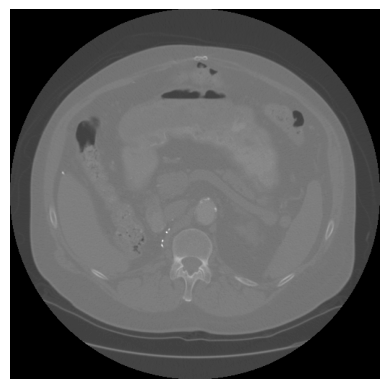

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

# 이미지 파일 불러오기
mhd_file = sitk.ReadImage(mhd_file_path)

# SimpleITK 이미지를 NumPy 배열로 변환
image_array = sitk.GetArrayFromImage(mhd_file)

# 첫 번째 이미지 선택 (다수의 이미지가 있다면 원하는 이미지를 선택해야 함)
image = image_array[0]

# 이미지 플로팅
plt.imshow(image, cmap='gray')
plt.axis('off')  # 축 제거
plt.show()

In [63]:
ct_scan = np.array(sitk.GetArrayFromImage(mhd_file), dtype=np.float32)

In [64]:
ct_scan.shape

(123, 512, 512)

In [65]:
# ct파일 HU를 -1000에서 3000을 1000으로 제한
ct_scan.clip(-1000, 1000, ct_scan)

array([[[-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        ...,
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.]],

       [[-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        ...,
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.]],

       [[-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        ...,
        [-10

In [66]:
import numpy as np

In [67]:
df_annotations[df_annotations['seriesuid'] == '1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886']

,seriesuid,coordX,coordY,coordZ,diameter_mm
762,1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644...,102.237729,65.328430,-240.695556,18.210145
763,1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644...,22.536168,34.721450,-117.437600,10.339713
764,1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644...,60.189477,-45.046760,-112.642780,8.349225
765,1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644...,67.827256,85.379925,-109.746724,32.270030
766,1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644...,114.105825,-11.856811,-165.621528,4.915613


In [68]:
mhd_file_path

'C:/Users/Taeho/Downloads/lung_cancer_project/data\\subset1\\subset1\\1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886.mhd'

In [69]:
origin_xyz = mhd_file.GetOrigin()
voxel_size_xyz = mhd_file.GetSpacing()
direction_matrix = np.array(mhd_file.GetDirection()).reshape(3, 3)

print(origin_xyz)

(-212.199997, -210.0, -338.0)


In [70]:
origin_xyz_np = np.array(origin_xyz)
voxel_size_xyz_np = np.array(voxel_size_xyz)

In [77]:
# Convert the coordinates of the center of the candidate
# from the patient coordinate system to column, row, index
cri = ((center_xyz - origin_xyz_np) @ np.linalg.inv(direction_matrix)) / voxel_size_xyz_np

# Since we'll be using column, row and index values to index into arrays,
# we round them to the nearest integer.
cri = np.round(cri)

# Going forward, we'll need the scan to be in the order index, row, column
irc = (int(cri[2]), int(cri[1]), int(cri[0]))

In [83]:
print(cri)
cri.shape

[232. 297.  73.]


(3,)

In [81]:
ct_scan.shape

(123, 512, 512)

In [84]:
dims_irc = (10, 18, 18)

In [85]:
# We will create three slices - one for each direction - to use to extract
# a region of interest from the CT scan
slice_list = []

for axis, center_val in enumerate(irc):
    
    # Get start and end index for the dimension so that the
    # nodule center is at the center of the 3d array we extract
    start_index = int(round(center_val - dims_irc[axis]/2))
    end_index = int(start_index + dims_irc[axis])

    # Adjust the indexes if the start_index is out of the CT scan array
    if start_index < 0:
        start_index = 0
        end_index = int(dims_irc[axis])
    
    # Do the same check for the end_index
    if end_index > ct_scan.shape[axis]:
        end_index = ct_scan.shape[axis]
        start_index = int(ct_scan.shape[axis] - dims_irc[axis])
        
    slice_list.append(slice(start_index, end_index))
    
tuple(slice_list)

(slice(68, 78, None), slice(288, 306, None), slice(223, 241, None))

In [86]:
ct_scan_chunk = ct_scan[tuple(slice_list)]
ct_scan_chunk.shape

(10, 18, 18)

In [87]:
# Create a tensor from the NumPy array of the CT scan chunk
ct_scan_chunk_tensor = torch.from_numpy(ct_scan_chunk)

# convert it to a tensor of float32
ct_scan_chunk_tensor = ct_scan_chunk_tensor.to(torch.float32)
    
# Add an extra dimension to represent a single channel in the 3d image
ct_scan_chunk_tensor = ct_scan_chunk_tensor.unsqueeze(0)

ct_scan_chunk_tensor.shape

torch.Size([1, 10, 18, 18])

In [90]:
candidate.is_nodule

True

In [99]:
torch.tensor([
    not candidate.is_nodule,
    candidate.is_nodule,
], dtype=torch.long)

tensor([0, 1])

In [98]:
candidates_clean[0].is_nodule

True

In [39]:
# We need to change the imports and use some other libraries for caching to work
# See: https://github.com/deep-learning-with-pytorch/dlwpt-code/issues/27

# !pip install diskcache cassandra-driver

In [37]:
# The code in this cell is from the Deep Learning with PyTorch book's GitHub repository
# https://github.com/deep-learning-with-pytorch/dlwpt-code/blob/master/util/disk.py

# The imports have slightly been modified to make the code work


import gzip

from cassandra.cqltypes import BytesType
from diskcache import FanoutCache, Disk, core
from diskcache.core import io, MODE_BINARY
from io import BytesIO

class GzipDisk(Disk):
    def store(self, value, read, key=None):

        # pylint: disable=unidiomatic-typecheck
        if type(value) is BytesType:
            if read:
                value = value.read()
                read = False

            str_io = BytesIO()
            gz_file = gzip.GzipFile(mode='wb', compresslevel=1, fileobj=str_io)

            for offset in range(0, len(value), 2**30):
                gz_file.write(value[offset:offset+2**30])
            gz_file.close()

            value = str_io.getvalue()

        return super(GzipDisk, self).store(value, read)


    def fetch(self, mode, filename, value, read):

        value = super(GzipDisk, self).fetch(mode, filename, value, read)

        if mode == MODE_BINARY:
            str_io = BytesIO(value)
            gz_file = gzip.GzipFile(mode='rb', fileobj=str_io)
            read_csio = BytesIO()

            while True:
                uncompressed_data = gz_file.read(2**30)
                if uncompressed_data:
                    read_csio.write(uncompressed_data)
                else:
                    break

            value = read_csio.getvalue()

        return value

def getCache(scope_str):
    return FanoutCache('data-unversioned/cache/' + scope_str,
                       disk=GzipDisk,
                       shards=64,
                       timeout=1,
                       size_limit=3e11,
                       )

raw_cache = getCache('ct_scan_raw')

@raw_cache.memoize(typed=True)
def getCtScanChunk(series_uid, center_xyz, dims_irc):

        filepaths = glob.glob(f'C:/Users/Taeho/Downloads/lung_cancer_project/data/subset*/*/{candidate.series_uid}.mhd')
        # filepaths = glob.glob('C:/Users/Taeho/Downloads/lung_cancer_project/data/subset0/subset0/*.mhd')


        assert len(filepaths) != 0, f'CT scan with seriesuid {series_uid} not found!'
        mhd_file_path = filepaths[0]
        
        mhd_file = sitk.ReadImage(mhd_file_path)
        ct_scan = np.array(sitk.GetArrayFromImage(mhd_file), dtype=np.float32)
        ct_scan.clip(-1000, 1000, ct_scan)
        
        origin_xyz = mhd_file.GetOrigin()
        voxel_size_xyz = mhd_file.GetSpacing()
        direction_matrix = np.array(mhd_file.GetDirection()).reshape(3, 3)
        
        origin_xyz_np = np.array(origin_xyz)
        voxel_size_xyz_np = np.array(voxel_size_xyz)
        
        cri = ((center_xyz - origin_xyz_np) @ np.linalg.inv(direction_matrix)) / voxel_size_xyz_np
        cri = np.round(cri)
        irc = (int(cri[2]), int(cri[1]), int(cri[0]))
        
        slice_list = []
        for axis, center_val in enumerate(irc):
            
            start_index = int(round(center_val - dims_irc[axis]/2))
            end_index = int(start_index + dims_irc[axis])
            
            if start_index < 0:
                start_index = 0
                end_index = int(dims_irc[axis])
                
            if end_index > ct_scan.shape[axis]:
                end_index = ct_scan.shape[axis]
                start_index = int(ct_scan.shape[axis] - dims_irc[axis])

            slice_list.append(slice(start_index, end_index))
            
        ct_scan_chunk = ct_scan[tuple(slice_list)]
        
        return ct_scan_chunk

In [40]:
class LunaDataset(Dataset):
    
    def __init__(self, is_validation_set=False, validation_stride=0):
        '''Create a PyTorch dataset for the CT scans
        
        If `is_validation_set` is `True` then every `validation_stride` item is kept.
        Otherwise, every `validation_stride` item is deleted
        '''
        
        # Make a copy of all the candidates.
        # Pick every 350th candidate so that we have about 1k candidates in the dataset
        # It takes agonizingly long to load more data!
        self.candidates = copy.copy(candidates_clean[::350])
        
        # If this is the validation set, keep every `validation_stride` item
        if is_validation_set:
            self.candidates = self.candidates[::validation_stride]
        
        # If this is the training set, delete every `validation_stride` item
        else:
            del self.candidates[::validation_stride]
            
    def __len__(self):
        '''Returns the number of items in the dataset'''
        return len(self.candidates)
    
    def __getitem__(self, i):
        '''Get the `i`the item in the dataset'''
        
        # Get the `i`th candidate
        candidate = self.candidates[i]
        
        # We want to resize each CT scan to the following dimensions
        dims_irc = (10, 18, 18)
        
        # Use the utility function to fetch the CT scan
        ct_scan_np = getCtScanChunk(candidate.series_uid, candidate.center_xyz, dims_irc)
        
        # Convert the CT scan to a tensor
        ct_scan_tensor = torch.from_numpy(ct_scan_np).to(torch.float32).unsqueeze(0)
        
        # Convert the target to a tensor
        label_tensor = torch.tensor([
            not candidate.is_nodule,
            candidate.is_nodule
        ], dtype=torch.long)
        
        return ct_scan_tensor, label_tensor

In [41]:
VALIDATION_STRIDE=10
BS=16

train_ds = LunaDataset(is_validation_set=False, validation_stride=VALIDATION_STRIDE)
val_ds = LunaDataset(is_validation_set=True, validation_stride=VALIDATION_STRIDE)

train_dl = DataLoader(train_ds, batch_size=BS, num_workers=0)
val_dl = DataLoader(val_ds, batch_size=BS, num_workers=0)

In [42]:
def train_loop(model, dataloader, criterion, optimizer, ds_size):
    '''Train the model for one epoch'''
    
    # Put the model in training mode to activate dropout
    model.train()
    
    # Keep a track of the loss and correct predictions for the epoch
    running_loss = 0.0
    running_corrects = 0
    
    # Track the total number of positives and true positives
    running_pos = 0
    running_pos_correct = 0
    
    # Track the total number of negatives and true negatives
    running_neg = 0
    running_neg_correct = 0
    
    for inputs, labels in tqdm(dataloader):
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # --- Standard PyTorch training process ---
        optimizer.zero_grad()
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        loss = criterion(outputs, labels[:,1])
        loss.backward()
        
        optimizer.step()
        # -----------------------------------------
        
        # Calculate loss and correct predictions in batch
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data[:,1])
        
        # Calculate positives and true positives in batch
        running_pos += labels.data[:,1].sum()
        running_pos_correct += ((preds == labels.data[:,1]) & (labels.data[:,1] == 1)).sum()
        
        # Calculate negatives and true negatives in batch
        running_neg += labels.data[:,0].sum()
        running_neg_correct += ((preds == labels.data[:,1]) & (labels.data[:,1] == 0)).sum()

    epoch_loss = running_loss / ds_size
    epoch_acc = running_corrects.double() / ds_size
    
    return epoch_loss, epoch_acc, (running_pos_correct, running_pos), (running_neg_correct, running_neg)
    
    

def eval_loop(model, dataloader, criterion, ds_size):
    '''Evaluate the model performance for one epoch'''

    # Put the model in evaluation mode to deactivate dropout
    model.eval()

    # Keep track of loss, predictions, and other numbers we are interested in
    # just like in the training loop
    running_loss = 0.0
    running_corrects = 0
    
    running_pos = 0
    running_pos_correct = 0
    running_neg = 0
    running_neg_correct = 0
    
    # Don't calculate gradients
    with torch.no_grad():
    
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
        
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels[:,1])
        
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data[:,1])
            
            running_pos += labels.data[:,1].sum()
            running_pos_correct += ((preds == labels.data[:,1]) & (labels.data[:,1] == 1)).sum()

            running_neg += labels.data[:,0].sum()
            running_neg_correct += ((preds == labels.data[:,1]) & (labels.data[:,1] == 0)).sum()
        
    epoch_loss = running_loss / ds_size
    epoch_acc = running_corrects.double() / ds_size
    
    return epoch_loss, epoch_acc, (running_pos_correct, running_pos), (running_neg_correct, running_neg)

In [43]:
class LunaModel(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        self.conv1 = nn.Conv3d(1, 32, kernel_size=3, padding=1, bias=True)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool3d(2)
        
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, padding=1, bias=True)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool3d(2)
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(2048, 1024)
        self.relu3 = nn.ReLU()
        
        self.dropout = nn.Dropout(0.2)
        
        self.fc2 = nn.Linear(1024, 2)
    
    def forward(self, X):
        
        # Dimensions of X => [BS, 1, 10, 18, 18]
        
        X = self.maxpool1(self.relu1(self.conv1(X)))
        X = self.maxpool2(self.relu2(self.conv2(X)))
        
        X = self.flatten(X)

        X = self.relu3(self.fc1(X))
        X = self.dropout(X)
        
        return self.fc2(X)

In [44]:
# Create an instance of the model
model = LunaModel()

# Use the GPU if it is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Use the cross-entropy loss function
criterion = nn.CrossEntropyLoss()

# Use the AdamW optimizer
optimizer = optim.AdamW(model.parameters(), weight_decay=0.1)

In [45]:
EPOCHS = 5

for epoch in range(EPOCHS):

    epoch_start = time.time()

    train_loss, train_acc, train_pos, train_neg = train_loop(
        model, train_dl, criterion,
        optimizer, len(train_ds)
    )

    val_loss, val_acc, val_pos, val_neg = eval_loop(
        model, val_dl, criterion, len(val_ds)
    )

    time_elapsed = time.time() - epoch_start
    print(f'Epoch: {epoch+1:02} | Epoch Time: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print()
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tTrain - correct pos: {train_pos[0]}/{train_pos[1]} | correct neg: {train_neg[0]}/{train_neg[1]}')
    print()
    print(f'\tVal. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%')
    print(f'\tVal. - correct pos: {val_pos[0]}/{val_pos[1]} | correct neg: {val_neg[0]}/{val_neg[1]}')
    print()

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 4s

	Train Loss: 0.247 | Train Acc: 99.38%
	Train - correct pos: 4/4 | correct neg: 1926/1938

	Val. Loss: 38.148 |  Val. Acc: 99.54%
	Val. - correct pos: 0/1 | correct neg: 215/215



  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 4s

	Train Loss: 81.074 | Train Acc: 99.12%
	Train - correct pos: 0/4 | correct neg: 1925/1938

	Val. Loss: 2.359 |  Val. Acc: 99.54%
	Val. - correct pos: 0/1 | correct neg: 215/215



  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 4s

	Train Loss: 2.025 | Train Acc: 99.38%
	Train - correct pos: 0/4 | correct neg: 1930/1938

	Val. Loss: 0.103 |  Val. Acc: 99.54%
	Val. - correct pos: 0/1 | correct neg: 215/215



  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 4s

	Train Loss: 0.335 | Train Acc: 99.79%
	Train - correct pos: 0/4 | correct neg: 1938/1938

	Val. Loss: 1.167 |  Val. Acc: 99.54%
	Val. - correct pos: 0/1 | correct neg: 215/215



  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 4s

	Train Loss: 1.822 | Train Acc: 99.79%
	Train - correct pos: 0/4 | correct neg: 1938/1938

	Val. Loss: 0.249 |  Val. Acc: 99.54%
	Val. - correct pos: 0/1 | correct neg: 215/215



In [101]:
# !pip install --upgrade tqdm
# pip install --upgrade ipywidgets
# !pip install torchvision
# !pip install torchsummary

In [47]:
torch.save(model.state_dict(), 'model_v3.pth')

In [48]:
model = LunaModel()  # 모델 인스턴스 생성
model.load_state_dict(torch.load("C:/Users/Taeho/Downloads/lung_cancer_project/model_v3.pth"))  # 저장된 모델의 상태를 불러옴
model.eval()  # 모델을 평가 모드로 설정 (필요한 경우)

LunaModel(
  (conv1): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)

In [50]:
import numpy as np
import SimpleITK as sitk

# mhd file 전처리
class MhdProcessor:
    def __init__(self, file_path):
        self.file_path = file_path

    def read_ct_scan(self):
        # .mhd 파일 읽기
        return sitk.ReadImage(self.file_path)

    def extract_chunk(self, dims_irc):
        mhd_file = self.read_ct_scan()
        ct_scan = np.array(sitk.GetArrayFromImage(mhd_file), dtype=np.float32)
        ct_scan.clip(-1000, 1000, ct_scan)

        origin_xyz = mhd_file.GetOrigin()
        voxel_size_xyz = mhd_file.GetSpacing()
        direction_matrix = np.array(mhd_file.GetDirection()).reshape(3, 3)

        origin_xyz_np = np.array(origin_xyz)
        voxel_size_xyz_np = np.array(voxel_size_xyz)

        center_xyz = np.array(ct_scan.shape) // 2  # 중심 좌표 추출
        cri = ((center_xyz - origin_xyz_np) @ np.linalg.inv(direction_matrix)) / voxel_size_xyz_np
        cri = np.round(cri)

        irc = (int(cri[2]), int(cri[1]), int(cri[0]))

        slice_list = []
        for axis, center_val in enumerate(irc):
            start_index = int(round(center_val - dims_irc[axis] / 2))
            end_index = int(start_index + dims_irc[axis])

            if start_index < 0:
                start_index = 0
                end_index = int(dims_irc[axis])

            if end_index > ct_scan.shape[axis]:
                end_index = ct_scan.shape[axis]
                start_index = int(ct_scan.shape[axis] - dims_irc[axis])

            slice_list.append(slice(start_index, end_index))
            
        ct_scan_chunk = ct_scan[tuple(slice_list)]
        return ct_scan_chunk

In [51]:
file_path = "C:/Users/Taeho/Downloads/lung_cancer_project/data/sample_nodule_data/754090/1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084993415992563148335.mhd"

In [52]:
processor = MhdProcessor(file_path)

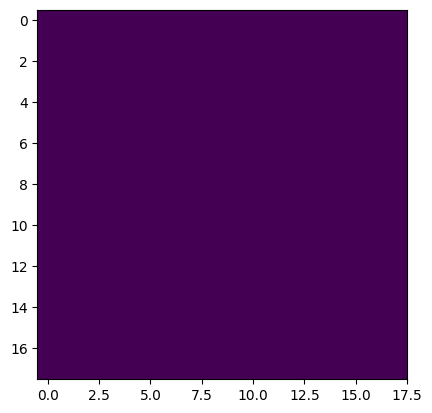

In [54]:
dims_irc = [10, 18, 18]
ct_scan_chunk = processor.extract_chunk(dims_irc)

plt.imshow(ct_scan_chunk[0])
plt.show()

In [66]:
ct_scan_tensor = torch.from_numpy(ct_scan_chunk).to(torch.float32).unsqueeze(0).unsqueeze(0)


with torch.no_grad():
    output = model(ct_scan_tensor)

# 예측 결과 출력
probability = torch.softmax(output, dim=1)[:, 1].item()  # 두 번째 클래스의 확률을 가져와서 확률로 변환
if probability > 0.5:
    print("이 환자는 폐암일 가능성이 {:.2f}% 입니다.".format(probability * 100))
else:
    print("이 환자는 정상일 가능성이 {:.2f}% 입니다.".format((1 - probability) * 100))


이 환자는 정상일 가능성이 100.00% 입니다.


In [65]:
torch.sigmoid(output)[0][1]

tensor(0.)

In [160]:
# .mhd 파일 경로
file_path = "C:/Users/Taeho/Downloads/lung_cancer_project/1.3.6.1.4.1.14519.5.2.1.6279.6001.970264865033574190975654369557.mhd"
mhd_file = sitk.ReadImage(mhd_file_path)
ct_scan = np.array(sitk.GetArrayFromImage(mhd_file), dtype=np.float32)
ct_scan.clip(-1000, 1000, ct_scan)

origin_xyz = mhd_file.GetOrigin()
voxel_size_xyz = mhd_file.GetSpacing()
direction_matrix = np.array(mhd_file.GetDirection()).reshape(3, 3)

origin_xyz_np = np.array(origin_xyz)
voxel_size_xyz_np = np.array(voxel_size_xyz)

cri = ((center_xyz - origin_xyz_np) @ np.linalg.inv(direction_matrix)) / voxel_size_xyz_np

cri = np.round(cri)

# Going forward, we'll need the scan to be in the order index, row, column
irc = (int(cri[2]), int(cri[1]), int(cri[0]))

dims_irc = (10, 18, 18)

slice_list = []

for axis, center_val in enumerate(irc):

    start_index = int(round(center_val - dims_irc[axis]/2))
    end_index = int(start_index + dims_irc[axis])

    if start_index < 0:
        start_index = 0
        end_index = int(dims_irc[axis])
    
    # Do the same check for the end_index
    if end_index > ct_scan.shape[axis]:
        end_index = ct_scan.shape[axis]
        start_index = int(ct_scan.shape[axis] - dims_irc[axis])
        
    slice_list.append(slice(start_index, end_index))
    
tuple(slice_list)

ct_scan_chunk = ct_scan[tuple(slice_list)]

ct_scan_chunk_tensor = torch.from_numpy(ct_scan_chunk)

ct_scan_chunk_tensor = ct_scan_chunk_tensor.to(torch.float32)
    
# ct_scan_chunk_tensor = ct_scan_chunk_tensor.unsqueeze(0)

print(ct_scan_chunk_tensor.shape)
print(type(ct_scan_chunk_tensor))
# candidate.is_nodule

ct_scan_np = np.array(ct_scan_chunk_tensor)

print(ct_scan_np.shape)
print(type(ct_scan_np))

torch.Size([10, 18, 18])
<class 'torch.Tensor'>
(10, 18, 18)
<class 'numpy.ndarray'>


In [41]:
import numpy as np
import torch
import SimpleITK as sitk

class MhdProcessor:
    def __init__(self, file_path):
        self.file_path = file_path

    def read_ct_scan(self):
        # .mhd 파일 읽기
        return sitk.ReadImage(self.file_path)

    def extract_chunk(self, dims_irc):
        mhd_file = self.read_ct_scan()
        ct_scan = np.array(sitk.GetArrayFromImage(mhd_file), dtype=np.float32)
        ct_scan.clip(-1000, 1000, ct_scan)

        origin_xyz = mhd_file.GetOrigin()
        voxel_size_xyz = mhd_file.GetSpacing()
        direction_matrix = np.array(mhd_file.GetDirection()).reshape(3, 3)

        origin_xyz_np = np.array(origin_xyz)
        voxel_size_xyz_np = np.array(voxel_size_xyz)

        center_xyz = np.array(ct_scan.shape) // 2  # 중심 좌표 추출
        cri = ((center_xyz - origin_xyz_np) @ np.linalg.inv(direction_matrix)) / voxel_size_xyz_np
        cri = np.round(cri)

        irc = (int(cri[2]), int(cri[1]), int(cri[0]))

        slice_list = []
        for axis, center_val in enumerate(irc):
            start_index = int(round(center_val - dims_irc[axis] / 2))
            end_index = int(start_index + dims_irc[axis])

            if start_index < 0:
                start_index = 0
                end_index = int(dims_irc[axis])

            if end_index > ct_scan.shape[axis]:
                end_index = ct_scan.shape[axis]
                start_index = int(ct_scan.shape[axis] - dims_irc[axis])

            slice_list.append(slice(start_index, end_index))

        ct_scan_chunk = ct_scan[tuple(slice_list)]
        return ct_scan_chunk

def main():
    file_path = "C:/Users/Taeho/Downloads/lung_cancer_project/1.3.6.1.4.1.14519.5.2.1.6279.6001.970264865033574190975654369557.mhd"
    dims_irc = (10, 18, 18)  # 크기 설정

    processor = MhdProcessor(file_path)
    ct_scan_chunk = processor.extract_chunk(dims_irc)

    print(ct_scan_chunk.shape)
    print(type(ct_scan_chunk))


if __name__ == "__main__":
    main()


(10, 18, 18)
<class 'numpy.ndarray'>


In [43]:
import numpy as np
import SimpleITK as sitk

class MhdProcessor:
    def __init__(self, file_path):
        self.file_path = file_path

    def read_ct_scan(self):
        # .mhd 파일 읽기
        return sitk.ReadImage(self.file_path)

    def extract_chunk(self, dims_irc):
        mhd_file = self.read_ct_scan()
        ct_scan = np.array(sitk.GetArrayFromImage(mhd_file), dtype=np.float32)
        ct_scan.clip(-1000, 1000, ct_scan)

        origin_xyz = mhd_file.GetOrigin()
        voxel_size_xyz = mhd_file.GetSpacing()
        direction_matrix = np.array(mhd_file.GetDirection()).reshape(3, 3)

        origin_xyz_np = np.array(origin_xyz)
        voxel_size_xyz_np = np.array(voxel_size_xyz)

        center_xyz = np.array(ct_scan.shape) // 2  # 중심 좌표 추출
        cri = ((center_xyz - origin_xyz_np) @ np.linalg.inv(direction_matrix)) / voxel_size_xyz_np
        cri = np.round(cri)

        irc = (int(cri[2]), int(cri[1]), int(cri[0]))

        slice_list = []
        for axis, center_val in enumerate(irc):
            start_index = int(round(center_val - dims_irc[axis] / 2))
            end_index = int(start_index + dims_irc[axis])

            if start_index < 0:
                start_index = 0
                end_index = int(dims_irc[axis])

            if end_index > ct_scan.shape[axis]:
                end_index = ct_scan.shape[axis]
                start_index = int(ct_scan.shape[axis] - dims_irc[axis])

            slice_list.append(slice(start_index, end_index))

        ct_scan_chunk = ct_scan[tuple(slice_list)]
        return ct_scan_chunk

# 전역 변수 선언
global_ct_scan_chunk = None

def main():
    global global_ct_scan_chunk  # 전역 변수 사용 선언
    file_path = "C:/Users/Taeho/Downloads/lung_cancer_project/1.3.6.1.4.1.14519.5.2.1.6279.6001.970264865033574190975654369557.mhd"
    dims_irc = (10, 18, 18)  # 크기 설정

    processor = MhdProcessor(file_path)
    global_ct_scan_chunk = processor.extract_chunk(dims_irc)  # 전역 변수에 데이터 할당

    print(global_ct_scan_chunk.shape)
    print(type(global_ct_scan_chunk))


if __name__ == "__main__":
    main()


(10, 18, 18)
<class 'numpy.ndarray'>


In [46]:
print(global_ct_scan_chunk.shape)
print(type(global_ct_scan_chunk))

(10, 18, 18)
<class 'numpy.ndarray'>


In [52]:
# chunk mp를 lunamodel로 classification
def evaluate_ct_scan(ct_scan_np):
    # Convert the CT scan to a tensor
    ct_scan_tensor = torch.from_numpy(ct_scan_np).to(torch.float32).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions

    # Forward pass through the model
    with torch.no_grad():
        outputs = model(ct_scan_tensor)

    # Get the predicted class
    _, predicted = torch.max(outputs.data, 1)
    class_index = predicted.item()

    # Map the class index to a label
    if class_index == 0:
        print("Predicted: Not a nodule")
        print("Confidence:", torch.sigmoid(outputs[0][0]).item())
    elif class_index == 1:
        print("Predicted: Nodule")
        print("Confidence:", torch.sigmoid(outputs[0][1]).item())

# Example usage:
# Assuming you have a CT scan numpy array named ct_scan_np
# Evaluate the CT scan
result = evaluate_ct_scan(global_ct_scan_chunk)

Predicted: Not a nodule
Confidence: 1.0


In [151]:
ct_scan_chunk
image_array = np.array(ct_scan_chunk_tensor)
image_array5

array([[[-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        ...,
        [-1000., -1000., -1000., ..., -1000.,  -997.,  -998.],
        [-1000., -1000., -1000., ...,  -999., -1000.,  -995.],
        [-1000., -1000., -1000., ...,  -993., -1000., -1000.]],

       [[-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        ...,
        [-1000., -1000., -1000., ...,  -989.,  -991.,  -998.],
        [-1000., -1000., -1000., ...,  -996.,  -985., -1000.],
        [-1000., -1000., -1000., ..., -1000.,  -999.,  -983.]],

       [[-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        ...,
        [-10

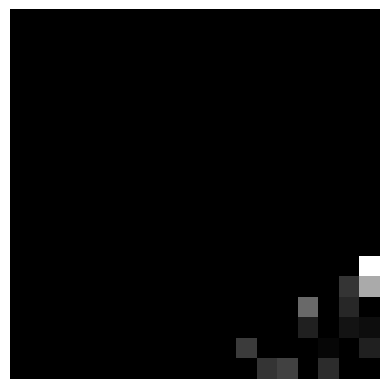

In [152]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

image = image_array[0]

# 이미지 플로팅
plt.imshow(image, cmap='gray')
plt.axis('off')  # 축 제거
plt.show()

In [162]:
image_array = sitk.GetArrayFromImage(mhd_file)

In [165]:
!pip install plotly

   ---------------------------------------- 0.0/16.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/16.4 MB 991.0 kB/s eta 0:00:17
   - -------------------------------------- 0.4/16.4 MB 5.3 MB/s eta 0:00:04
   -- ------------------------------------- 1.0/16.4 MB 7.6 MB/s eta 0:00:03
   --- ------------------------------------ 1.5/16.4 MB 8.7 MB/s eta 0:00:02
   ----- ---------------------------------- 2.1/16.4 MB 9.4 MB/s eta 0:00:02
   ------ --------------------------------- 2.6/16.4 MB 9.6 MB/s eta 0:00:02
   ------- -------------------------------- 3.0/16.4 MB 9.7 MB/s eta 0:00:02
   -------- ------------------------------- 3.6/16.4 MB 9.9 MB/s eta 0:00:02
   ---------- ----------------------------- 4.1/16.4 MB 10.1 MB/s eta 0:00:02
   ----------- ---------------------------- 4.7/16.4 MB 10.3 MB/s eta 0:00:02
   ------------ --------------------------- 5.2/16.4 MB 10.4 MB/s eta 0:00:02
   -------------- ------------------------- 5.8/16.4 MB 10.5 MB/s eta 0:00:02


In [168]:
import plotly.graph_objs as go
import plotly.io as pio

# ct_scan_chunk는 numpy 배열로 가정합니다.

# Plotly 3D scatter plot을 생성합니다.
fig = go.Figure(data=[go.Scatter3d(
    x=image_array[:, :, :].nonzero()[0],
    y=image_array[:, :, :].nonzero()[1],
    z=image_array[:, :, :].nonzero()[2],
    mode='markers',
    marker=dict(
        size=1,
        color='blue',                # Marker color can be a single color
        opacity=0.8
    )
)])

# 그래프의 레이아웃을 설정합니다.
fig.update_layout(
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z')
    )
)

# 그래프를 표시합니다.
pio.show(fig)


In [ ]:
np.shape(image_array)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

# 이미지 파일 불러오기
mhd_file = sitk.ReadImage(file_path)

# SimpleITK 이미지를 NumPy 배열로 변환
image_array = sitk.GetArrayFromImage(mhd_file)

# 첫 번째 이미지 선택 (다수의 이미지가 있다면 원하는 이미지를 선택해야 함)
image = image_array[0]

# 이미지 플로팅
plt.imshow(image, cmap='gray')
plt.axis('off')  # 축 제거
plt.show()